# Bước 5: So sánh Apriori vs FP-Growth

Mục tiêu:

- Chạy Apriori và FP-Growth trên cùng một `basket_bool`
- So sánh:
  - Thời gian chạy
  - Số lượng tập mục phổ biến (frequent itemsets)
  - Số lượng luật kết hợp sinh ra
  - Độ dài trung bình của itemset
- Minh hoạ bằng biểu đồ để sinh viên thấy rõ trade-off giữa:
  - Độ đầy đủ của luật
  - Thời gian tính toán
  - Tính phù hợp với dữ liệu lớn


In [1]:
# PARAMETERS (for papermill)

BASKET_BOOL_PATH = "data/processed/basket_bool.parquet"

# Dùng chung tham số với hai thuật toán
MIN_SUPPORT = 0.01
MAX_LEN = 3
METRIC = "lift"
MIN_THRESHOLD = 1.0


In [2]:
# Parameters
BASKET_BOOL_PATH = "data/processed/basket_bool.parquet"
MIN_SUPPORT = 0.01
MAX_LEN = 3
METRIC = "lift"
MIN_THRESHOLD = 1.0


## Set up

In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Determine correct project root
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from cluster_library import (
    benchmark_apriori_vs_fpgrowth,
    AssociationRulesMiner,
    FPGrowthMiner,
    DataVisualizer,
)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12


## Tải basket_bool

In [4]:
basket_bool = pd.read_parquet(BASKET_BOOL_PATH)

print("=== Thông tin basket_bool ===")
print(f"- Số hoá đơn (rows): {basket_bool.shape[0]:,}")
print(f"- Số sản phẩm (columns): {basket_bool.shape[1]:,}")
print(f"- Tỷ lệ ô = 1 (có mua): {basket_bool.values.mean():.4f}")


=== Thông tin basket_bool ===
- Số hoá đơn (rows): 16,646
- Số sản phẩm (columns): 3,844
- Tỷ lệ ô = 1 (có mua): 0.0054


## Chạy benchmark

In [5]:
result = benchmark_apriori_vs_fpgrowth(
    basket_bool=basket_bool,
    min_support=MIN_SUPPORT,
    max_len=MAX_LEN,
    metric=METRIC,
    min_threshold=MIN_THRESHOLD,
)

summary = result["summary"]
summary


,algorithm,runtime_sec,n_itemsets,n_rules,avg_itemset_length
0,apriori,6.869083,968,942,1.42562
1,fpgrowth,1.959204,968,942,1.42562


## Biểu đồ so sánh thời gian

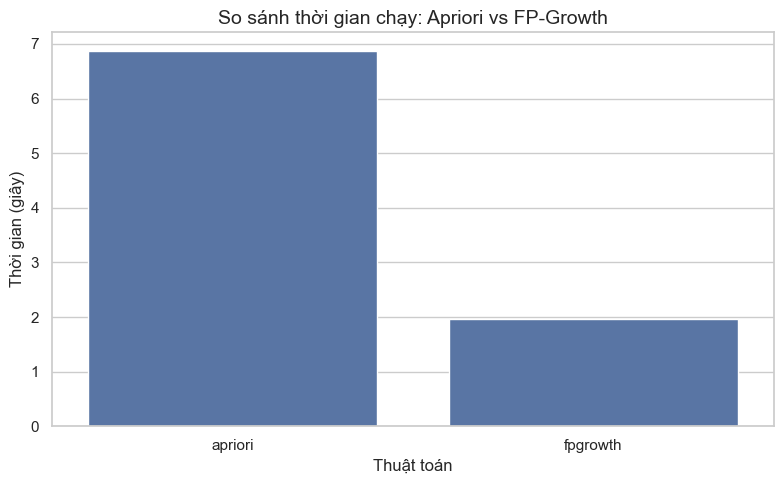

In [6]:
plt.figure()
sns.barplot(data=summary, x="algorithm", y="runtime_sec")
plt.title("So sánh thời gian chạy: Apriori vs FP-Growth")
plt.ylabel("Thời gian (giây)")
plt.xlabel("Thuật toán")
plt.tight_layout()
plt.show()


## Biểu đồ số lượng itemsets & rules

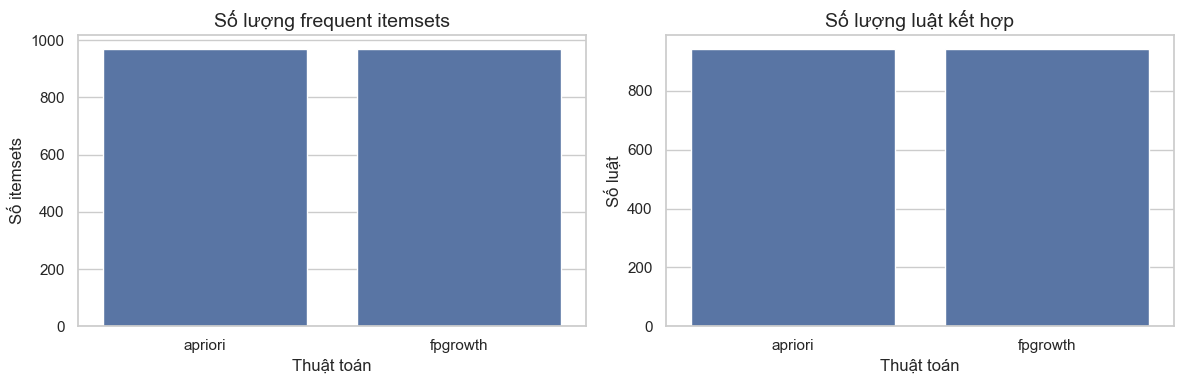

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=summary, x="algorithm", y="n_itemsets", ax=axes[0])
axes[0].set_title("Số lượng frequent itemsets")
axes[0].set_xlabel("Thuật toán")
axes[0].set_ylabel("Số itemsets")

sns.barplot(data=summary, x="algorithm", y="n_rules", ax=axes[1])
axes[1].set_title("Số lượng luật kết hợp")
axes[1].set_xlabel("Thuật toán")
axes[1].set_ylabel("Số luật")

plt.tight_layout()
plt.show()


## Độ dài trung bình iemset

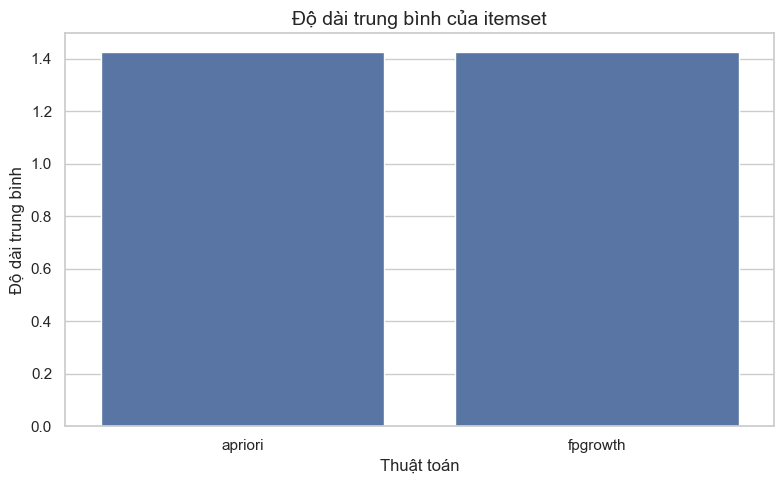

In [8]:
plt.figure()
sns.barplot(data=summary, x="algorithm", y="avg_itemset_length")
plt.title("Độ dài trung bình của itemset")
plt.xlabel("Thuật toán")
plt.ylabel("Độ dài trung bình")
plt.tight_layout()
plt.show()


## Một vài luật tiêu biểu từ mỗi thuật toán

In [9]:
cols_preview = [
    "antecedents_str",
    "consequents_str",
    "support",
    "confidence",
    "lift",
]

ap_rules = result["apriori_rules"].copy()
fp_rules = result["fpgrowth_rules"].copy()

# Thêm dạng chuỗi dễ đọc nếu chưa có (tuỳ trường hợp gọi)
if "antecedents_str" not in ap_rules.columns:
    miner_ap_tmp = AssociationRulesMiner(basket_bool=basket_bool)
    miner_ap_tmp.frequent_itemsets = result["apriori_itemsets"]
    miner_ap_tmp.rules = ap_rules
    ap_rules = miner_ap_tmp.add_readable_rule_str()

if "antecedents_str" not in fp_rules.columns:
    miner_fp_tmp = FPGrowthMiner(basket_bool=basket_bool)
    miner_fp_tmp.frequent_itemsets = result["fpgrowth_itemsets"]
    miner_fp_tmp.rules = fp_rules
    fp_rules = miner_fp_tmp.add_readable_rule_str()

print("=== Top 10 luật Apriori (theo lift) ===")
display(
    ap_rules.sort_values("lift", ascending=False)[cols_preview].head(10)
)

print("=== Top 10 luật FP-Growth (theo lift) ===")
display(
    fp_rules.sort_values("lift", ascending=False)[cols_preview].head(10)
)


=== Top 10 luật Apriori (theo lift) ===


,antecedents_str,consequents_str,support,confidence,lift
895,HERB MARKER THYME,HERB MARKER ROSEMARY,0.010153,0.944134,86.829038
894,HERB MARKER ROSEMARY,HERB MARKER THYME,0.010153,0.933702,86.829038
593,REGENCY TEA PLATE GREEN,REGENCY TEA PLATE ROSES,0.011534,0.845815,52.930211
592,REGENCY TEA PLATE ROSES,REGENCY TEA PLATE GREEN,0.011534,0.721805,52.930211
908,POPPY'S PLAYHOUSE LIVINGROOM,POPPY'S PLAYHOUSE BEDROOM,0.010153,0.808612,51.769856
909,POPPY'S PLAYHOUSE BEDROOM,POPPY'S PLAYHOUSE LIVINGROOM,0.010153,0.650000,51.769856
842,SET OF 3 WOODEN STOCKING DECORATION,SET OF 3 WOODEN TREE DECORATIONS,0.010333,0.690763,50.211536
843,SET OF 3 WOODEN TREE DECORATIONS,SET OF 3 WOODEN STOCKING DECORATION,0.010333,0.751092,50.211536
768,POPPY'S PLAYHOUSE LIVINGROOM,POPPY'S PLAYHOUSE KITCHEN,0.010693,0.851675,49.225611
769,POPPY'S PLAYHOUSE KITCHEN,POPPY'S PLAYHOUSE LIVINGROOM,0.010693,0.618056,49.225611


=== Top 10 luật FP-Growth (theo lift) ===


,antecedents_str,consequents_str,support,confidence,lift
895,HERB MARKER THYME,HERB MARKER ROSEMARY,0.010153,0.944134,86.829038
894,HERB MARKER ROSEMARY,HERB MARKER THYME,0.010153,0.933702,86.829038
587,REGENCY TEA PLATE GREEN,REGENCY TEA PLATE ROSES,0.011534,0.845815,52.930211
586,REGENCY TEA PLATE ROSES,REGENCY TEA PLATE GREEN,0.011534,0.721805,52.930211
896,POPPY'S PLAYHOUSE LIVINGROOM,POPPY'S PLAYHOUSE BEDROOM,0.010153,0.808612,51.769856
897,POPPY'S PLAYHOUSE BEDROOM,POPPY'S PLAYHOUSE LIVINGROOM,0.010153,0.650000,51.769856
828,SET OF 3 WOODEN STOCKING DECORATION,SET OF 3 WOODEN TREE DECORATIONS,0.010333,0.690763,50.211536
829,SET OF 3 WOODEN TREE DECORATIONS,SET OF 3 WOODEN STOCKING DECORATION,0.010333,0.751092,50.211536
766,POPPY'S PLAYHOUSE LIVINGROOM,POPPY'S PLAYHOUSE KITCHEN,0.010693,0.851675,49.225611
767,POPPY'S PLAYHOUSE KITCHEN,POPPY'S PLAYHOUSE LIVINGROOM,0.010693,0.618056,49.225611
